In [5]:
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import colorcet as cc
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct
from nupack import *

from nnn.util import *
from nnn.fileio import *
from nnn.processing import *
from nnn.plotting import *
import nnn.motif_fit as mf

from nnn import util, fileio, processing, plotting, motif_fit, simulation
from nnn.arraydata import ErrorAdjust, ArrayData

import warnings
warnings.filterwarnings("ignore")

palette = cc.glasbey_dark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
annotation = fileio.read_annotation('./data/annotation/nnnlib2b_annotation_20220418.tsv')
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220418.tsv')
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file='./data/annotation/NNNlib2b_annotation_20220418.tsv')

In [27]:
annotation.ConstructType.values.astype(str)

array(['NN', 'NN', 'NN', ..., 'pseudoknot_pt_muts', 'pseudoknot_pt_muts',
       'pseudoknot_pt_muts'], dtype='<U18')

In [30]:
np.unique(annotation.ConstructType.values.astype(str))

array(['3mer', 'AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos', 'NN', 'NNN', 'NNN_3primebulge',
       'NNN_5prime_bulge', 'NN_3primebulge', 'NN_5primebulge',
       'PUMcontrols', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p',
       'StemDangle_53p', 'StemDangle_5p', 'SuperStem', 'VARloop',
       'VariableLoops', 'WBcontrols', 'WC_5ntstem', 'WC_6ntstem',
       'WC_7ntstem', 'pseudoknot_pt_muts', 'pseudoknots'], dtype='<U18')

In [31]:
arr = arraydata.data.join(arraydata.annotation)
# for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
#     arr[f'd{param}'] = util.get_ddX(arr, param, 'ConstructType')
# arr['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(arr, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

salt = saltdata.data.join(saltdata.annotation)
# for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
#     salt[f'd{param}'] = util.get_ddX(salt, param, 'ConstructType')
# salt['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(salt, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
# salt['ddG_37_NUPACK_150mM'] = util.get_ddX(salt, 'dG_37_NUPACK_150mM', 'ConstructType')
salt['scaffold'] = salt.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

In [35]:
df = arr.query('Series == "WatsonCrick"')

In [36]:
feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop')

y = df['dG_37']
y_err = df['dG_37_se']
A = feats / y_err.values.reshape(-1,1)
b = (y/y_err).values

In [37]:
np.linalg.matrix_rank(A)

16

In [49]:
u,s,v = np.linalg.svd(A)

plt.plot(s / s[0])
s[-1] / s[0]

In [85]:
s_inv = 1/s
s_inv[s < s[0]*0.0] = 0

In [86]:
nn_se = np.sqrt(np.sum((v * s_inv.reshape(1,-1))**2, axis=1))
nn_se

array([0.01494699, 0.00747069, 0.00763439, 0.00697167, 0.01225667,
       0.00475212, 0.006913  , 0.00959999, 0.00588524, 0.00645596,
       0.00702121, 0.02086175, 0.01321173, 0.0104923 , 0.03051618,
       0.03627451, 0.0198415 , 0.01957365, 0.0113496 , 0.0313225 ])

In [101]:
ubs = (u * b.reshape(-1,1))[:,:M] * s_inv.reshape(1,-1)
# nn = np.sum(u * b.reshape(-1,1) * s_inv.reshape(1,-1) * v, axis=1)

In [95]:
b.shape

(2629,)

In [103]:
ubs.shape

(2629, 20)

In [100]:
M=20

Rank of the design matrix A is 4 / 4
Rank of the design matrix A is 20 / 20
Rank of the design matrix A is 80 / 80


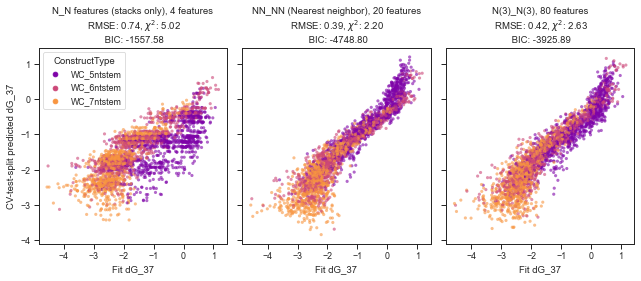

In [312]:
coef_dfs, motif_se, feats, preds, results = mf.fit_linear_motifs(df, feature_method='get_stack_feature_list', err='_se', stack_sizes=[1,2,3])
save_fig('./fig/motif_fit/WC_N-NN-NNN_dG_37.pdf')

Rank of the design matrix A is 80 / 80


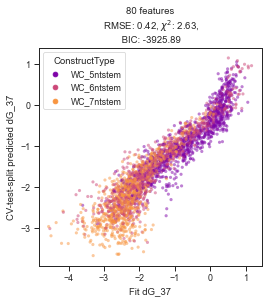

In [268]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list', err='_se', stack_size=3)

Rank of the design matrix A is 80 / 80


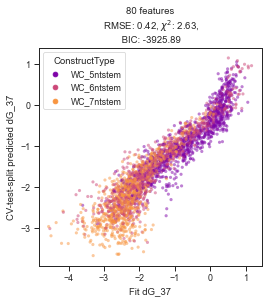

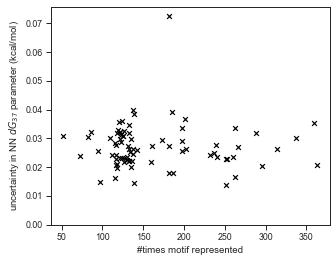

In [271]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list', err='_se', stack_size=3)

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(np.sum(feats, axis=0), motif_df.dG_37_se, color='k', marker='x')
plt.ylim(bottom=0)
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $dG_{37}$ parameter (kcal/mol)')
save_fig('./fig/motif_fit/WC_uncertainty_dG_37_vs_motif_freq.pdf')

Rank of the design matrix A is 20 / 20


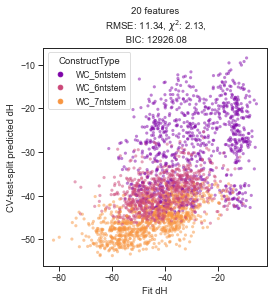

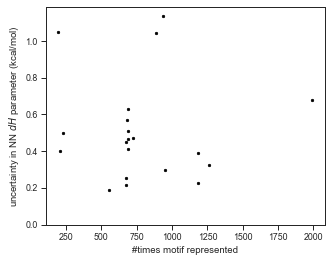

In [17]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', param='dH', err='_se')

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(np.sum(feats, axis=0), motif_df.dH_se, color='k', marker='.')
plt.ylim(bottom=0)
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $dH$ parameter (kcal/mol)')
save_fig('./fig/motif_fit/WC_uncertainty_dH_vs_motif_freq.pdf')

Rank of the design matrix A is 80 / 80


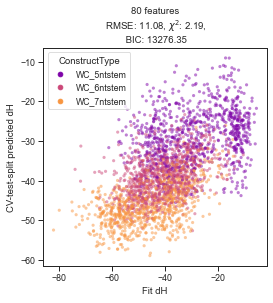

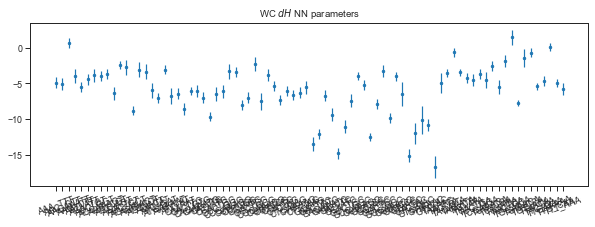

In [277]:
param = 'dH'

motif_df, _ = mf.fit_NN_cv(df, feature_method='get_stack_feature_list', param=param, err='_se', stack_size=3)

plot_motif_param_errorbar(motif_df, param)
save_fig('./fig/motif_fit/WC_NN_param_%s.pdf'%param)
plt.show()

In [278]:
motif_df

,dH,dH_cv_std,dH_se
motif,,,
AAA_TTT,-4.910997,0.443588,0.783361
AAC_GTT,-5.037276,0.418201,0.842302
AAGAAATT,0.656971,0.769375,0.717515
AAG_CTT,-3.890543,0.434557,0.987862
AAT_ATT,-5.489853,0.514094,0.730110
...,...,...,...
TTA_TAA,-5.420602,0.989849,0.540663
TTC_GAA,-4.647544,0.177132,0.659382
TTGAAAAA,0.077674,1.629349,0.557611


Rank of the design matrix A is 20 / 20


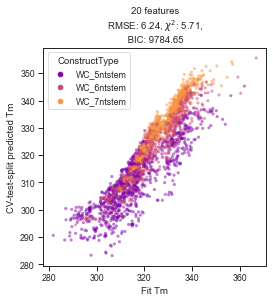

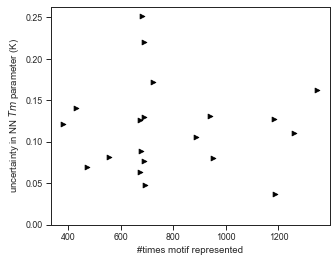

In [265]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list', param='Tm', err='_se')

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(np.sum(feats, axis=0), motif_df.Tm_se, color='k', marker='>')
plt.ylim(bottom=0)
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $Tm$ parameter (K)')

save_fig('./fig/motif_fit/WC_uncertainty_Tm_vs_motif_freq.pdf')

### NNN

In [239]:
feats.shape

(2629, 84)

In [246]:
motif_df.index

Index(['AAA_TTT', 'AAC_GTT', 'AAG_CTT', 'AAT_ATT', 'ACA_TGT', 'ACC_GGT',
       'ACG_CGT', 'ACT_AGT', 'AGA_TCT', 'AGC_GCT', 'AGG_CCT', 'AGT_ACT',
       'ATA_TAT', 'ATC_GAT', 'ATG_CAT', 'ATT_AAT', 'CAA_TTG', 'CAC_GTG',
       'CAG_CTG', 'CAT_ATG', 'CCA_TGG', 'CCC_GGG', 'CCG_CGG', 'CCT_AGG',
       'CGA_TCG', 'CGC_GCG', 'CGG_CCG', 'CGT_ACG', 'CTA_TAG', 'CTC_GAG',
       'CTG_CAG', 'CTT_AAG', 'GAA_TTC', 'GAC_GTC', 'GAG_CTC', 'GAT_ATC',
       'GCA_TGC', 'GCC_GGC', 'GCG_CGC', 'GCT_AGC', 'GGA_TCC', 'GGC_GCC',
       'GGG_CCC', 'GGT_ACC', 'GTA_TAC', 'GTC_GAC', 'GTG_CAC', 'GTT_AAC',
       'TAA_TTA', 'TAC_GTA', 'TAG_CTA', 'TAT_ATA', 'TCA_TGA', 'TCC_GGA',
       'TCG_CGA', 'TCT_AGA', 'TGA_TCA', 'TGC_GCA', 'TGG_CCA', 'TGT_ACA',
       'TTA_TAA', 'TTC_GAA', 'TTG_CAA', 'TTT_AAA', 'XAA_TTY', 'XAC_GTY',
       'XAG_CTY', 'XAT_ATY', 'XCA_TGY', 'XCC_GGY', 'XCG_CGY', 'XCT_AGY',
       'XGA_TCY', 'XGC_GCY', 'XGG_CCY', 'XGT_ACY', 'XTA_TAY', 'XTC_GAY',
       'XTG_CAY', 'XTT_AAY', 'XXA_TYY', 'XXC_GYY', 

Rank of the design matrix A is 80 / 80


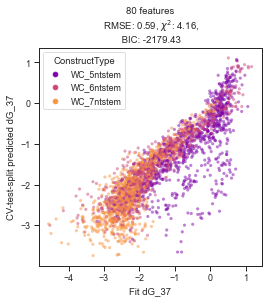

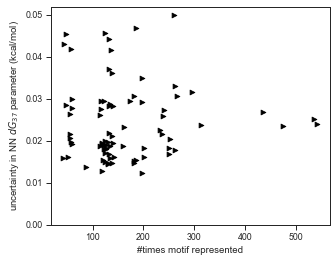

In [266]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', param='dG_37', err='_se', stack_size=3)

fig, ax = plt.subplots(figsize=(5,4))

plt.scatter(np.sum(feats, axis=0), motif_df.dG_37_se, color='k', marker='>')

# freq = np.sum(feats, axis=0)
# for i in range(feats.shape[1]):
#     if motif_df.dG_37_se[i] < 1e6:
#         plt.text(freq[i], motif_df.dG_37_se[i], feats.columns[i], color='k')

plt.ylim(bottom=0)
# plt.yscale('log')
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $dG_{37}$ parameter (kcal/mol)')
save_fig('./fig/motif_fit/WC_uncertainty_NNN_dG_37_vs_motif_freq.pdf')

In [ ]:
compare_fit_with_santalucia(df, santa_lucia, params=['dH', 'dS', 'dG_37'])

## mismatches

In [280]:
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_struct.tsv')

In [284]:
np.unique(annotation.Series)

array(['BaeControls', 'Bulges', 'MisMatchesACanyPos',
       'MisMatchesCentered', 'MisMatchesGTanyPos', 'PUMcontrols',
       'PolyNTControls', 'PseudoKnots', 'REPeatControls', 'StemDangle',
       'SuperStem', 'TETRAloop', 'TRIloop', 'VariableLoops', 'WBcontrols',
       'WatsonCrick'], dtype=object)

In [286]:
from nnn import feature_list

In [314]:
variant = annotation.query("Series == 'MisMatchesACanyPos'").iloc[0,:]
feature_list.get_mismatch_stack_feature_list(variant, stack_size=2)

['GGAAAC', 'AG_CC', 'AA_CT', 'AA_TT', 'AA_TT', 'AA_TT', 'GA_TC', 'xG_Cy']

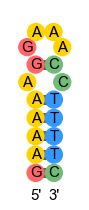

In [293]:
draw_struct(variant.RefSeq, variant.TargetStruct)

In [321]:
np.unique(df.Series)

array(['WatsonCrick'], dtype=object)

In [317]:
mf.get_feature_count_matrix(df.query("Series == 'MisMatchesACanyPos'"), feature_method='get_mismatch_stack_feature_list', stack_size=2)

ValueError: Columns must be same length as key

In [315]:
motif_df, feats = mf.fit_NN_cv(df.query("Series == 'MisMatchesACanyPos'"), feature_method='get_mismatch_stack_feature_list', param='dG_37', err='_se')


ValueError: Columns must be same length as key